In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

data_path = 'files_to_analyze'
output_path = 'output'

In [3]:
def pickle_csv_dataset(dataset, csv_paths):
    
    # Gather session_info from the first CSV of a dataset
    first_csv = csv_paths[0]
    session_id = None
    channel_error = False # flag for future checkpoint
    with open(first_csv, 'r') as file:
        lines = file.readlines() # load .csv data lines into memory

        # load desired session parameters
        session_id = float(next(line.split(',')[1] for line in lines if line.startswith('Session #,')))
        num_channels = int(float(next(line.split(',')[1] for line in lines if line.startswith('# of Channels,'))))
        scan_rate = float(next(line.split(',')[1] for line in lines if line.startswith('Scan Rate (Hz),')))
        num_samples = float(next(line.split(',')[1] for line in lines if line.startswith('Samples/Channel,')))
        
        stim_duration = float(next(line.split(',')[1] for line in lines if line.startswith('Stimulus duration (ms),')))
        stim_interval = float(next(line.split(',')[1] for line in lines if line.startswith('Inter-Stim delay (sec),')))
        
        emg_amp_gains = []
        for line in lines:
            if line.startswith('EMG amp gain ch'):
                emg_amp_gains.append(int(float(line.split(',')[1])))

    # Create a dictionary to store the session data
    session_data = {
        'session_info': {
            'session_name' : dataset,
            'num_channels': num_channels,
            'scan_rate': int(scan_rate),
            'num_samples': int(num_samples),
            'stim_duration' : stim_duration,
            'stim_interval' : stim_interval,
            'emg_amp_gains': emg_amp_gains
        },
        'recordings': []
    }

    # Process each recording for stimulus and EMG data
    unsaved_data_files = [] # initilizing list for data files that flagged errors.
    for recording_file in csv_paths:  # Replace with your list of recording files
        with open(recording_file, 'r') as file:
            lines = file.readlines() # load CSV lines into memory.
            test_session_id = float(next(line.split(',')[1] for line in lines if line.startswith('Session #,')))
            
            if test_session_id != session_id: # Test if a second session's file is detected
                unsaved_data_files.append(recording_file)
                continue
        
            # Extract Stimulus Value (in volts)
            stimulus_v = float(next(line.split(',')[1] for line in lines if line.startswith('Stimulus Value (V),')))

            # Extract EMG "Recorded Data (mV)"
            start_index = None
            data_lines = []
            for i, line in enumerate(lines):
                if line.startswith("Recorded Data (mV),"):
                    start_index = i + 1
                elif start_index is not None:
                    data_lines.extend([value.split(',') for value in line.strip().split('\n')])
                    if line.strip() == "":
                        break

            if num_channels != len(data_lines[0]): # test for a mis-match in the cvs number of channels and the declared number of channels.
                unsaved_data_files.append(recording_file)
                channel_error = True
                continue
            
            # Create a list to store data for each channel
            channel_data = [[] for _ in range(num_channels)]

            # Populate the channel data
            for row in data_lines:
                for i, value in enumerate(row):
                    channel_data[i].append(float(value))

            # Update the session_data with the number of channels and channel_data
            session_data['session_info']['num_channels'] = num_channels
            session_data['recordings'].append({
                'stimulus_v': stimulus_v,
                'channel_data': channel_data
            })
                
    #Check for channel recording errors.
    if channel_error:
        print(f'>! Error: mis-match in declared and recorded channels detected in {dataset}.')
        print('\tData from the following recordings were not saved to the session data file:')
        for file in unsaved_data_files:
            print(f'\t\t{file}')
        pass
    # Check for unsaved files with errors.
    if len(unsaved_data_files) > 0 and not channel_error:
        print(f'>! Error: multiple recording sessions detected in {dataset}.')
        print('\tData from the following recordings were not saved to the session data file:')
        for file in unsaved_data_files:
            print(f'\t\t{file}')
        pass

    # Save the session data to its own pickle file
    save_name = dataset + '_data.pickle'
    with open(os.path.join(output_path, save_name), 'wb') as pickle_file:
        pickle.dump(session_data, pickle_file)

    # Return the number of CSV files attempted and successfully processed.
    num_csvs = len(csv_paths)
    num_csv_success = len(csv_paths) - len(unsaved_data_files)
    return num_csvs, num_csv_success

In [4]:
# Process files_to_analyze into Pickle files
datasets = [dir for dir in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, dir))] # list all datasets in "files_to_analyze" folder
print(f'Datasets to process: {datasets}')

# Create a pickle file for each dataset in files_to_analyze
for dataset in datasets:
    dataset_path = os.path.join(data_path, dataset)#.replace('\\', '/')
    
    csv_regex = re.compile(r'.*\.csv$') #regex to match CSV files only.
    csv_names = [item for item in os.listdir(dataset_path) if csv_regex.match(item)] #list of CSV filenames in dataset_path.
    csv_paths = [os.path.join(dataset_path, csv_name) for csv_name in csv_names]

    # check if there are CSVs in this dataset.
    if len(csv_paths) <= 0:
        print(f'>! Error: no CSV files detected in "{dataset}." Make sure you converted STMs to CSVs.')
        continue

    # Call function to extract dataset CSVs into a pickle file.
    num_csvs, num_csv_success = pickle_csv_dataset(dataset, csv_paths)
    print(f'> {num_csv_success} of {num_csvs} CSVs processed from dataset "{dataset}".')

print('Processing complete.')

#institute checks for:
    #has any CSVs -- forgot to convert?
#then extract session info from first file (EMG amp gains, scan rate)

Datasets to process: ['240404-1', '240404-13', '240404-2', '240404-3', '240404-4', '240404-5', '240404-9', 'hidden']
> 28 of 28 CSVs processed from dataset "240404-1".
> 31 of 31 CSVs processed from dataset "240404-13".
> 67 of 67 CSVs processed from dataset "240404-2".
> 66 of 66 CSVs processed from dataset "240404-3".
> 58 of 58 CSVs processed from dataset "240404-4".
> 56 of 56 CSVs processed from dataset "240404-5".
> 40 of 40 CSVs processed from dataset "240404-9".
>! Error: no CSV files detected in "hidden." Make sure you converted STMs to CSVs.
Processing complete.


In [5]:
# Load test_data pickle
import pickle

pickled_test_data = 'output/240404-4_data.pickle' #'output/040224rec1_data.pickle'

# Load the session data from the pickle file
with open(pickled_test_data, 'rb') as pickle_file:
    session_data = pickle.load(pickle_file)

# Access session-wide information
session_info = session_data['session_info']
session_name = session_info['session_name']
num_channels = session_info['num_channels']
scan_rate = session_info['scan_rate']
num_samples = session_info['num_samples']
stim_duration = session_info['stim_duration']
stim_interval = session_info['stim_interval']
emg_amp_gains = session_info['emg_amp_gains']

print(f"Session Name: {session_name}")
print(f"# of Channels: {num_channels}")
print(f"Scan rate (Hz): {scan_rate}")
print(f"Samples/Channel: {num_samples}")
print(f"Stimulus duration (ms): {stim_duration}")
print(f"Stimulus interval (s): {stim_interval}")
print(f"EMG amp gains: {emg_amp_gains}")

# Access recordings
recordings = session_data['recordings']
for recording in recordings:
    stimulus_v = recording['stimulus_v']
    channel_data = recording['channel_data']
    print(f"Stimulus Voltage: {stimulus_v}")
    for i, channel_data_array in enumerate(channel_data):
        print(f"Channel {i} data length: {len(channel_data_array)}")

Session Name: 240404-4
# of Channels: 2
Scan rate (Hz): 10000
Samples/Channel: 1510
Stimulus duration (ms): 0.1
Stimulus interval (s): 3.0
EMG amp gains: [500, 500, 500, 500, 500, 500]
Stimulus Voltage: 0.01
Channel 0 data length: 1510
Channel 1 data length: 1510
Stimulus Voltage: 0.034884
Channel 0 data length: 1510
Channel 1 data length: 1510
Stimulus Voltage: 0.059792
Channel 0 data length: 1510
Channel 1 data length: 1510
Stimulus Voltage: 0.084552
Channel 0 data length: 1510
Channel 1 data length: 1510
Stimulus Voltage: 0.109492
Channel 0 data length: 1510
Channel 1 data length: 1510
Stimulus Voltage: 0.134326
Channel 0 data length: 1510
Channel 1 data length: 1510
Stimulus Voltage: 0.159262
Channel 0 data length: 1510
Channel 1 data length: 1510
Stimulus Voltage: 0.184183
Channel 0 data length: 1510
Channel 1 data length: 1510
Stimulus Voltage: 0.209099
Channel 0 data length: 1510
Channel 1 data length: 1510
Stimulus Voltage: 0.233858
Channel 0 data length: 1510
Channel 1 data le

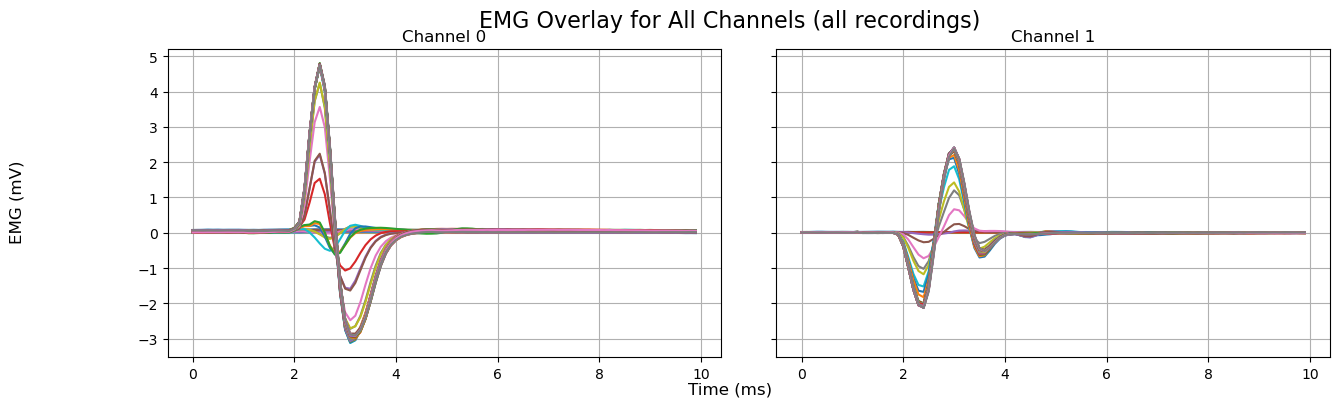

In [6]:
# Plot EMG data for all channels

# Load the session data from the pickle file
with open(pickled_test_data, 'rb') as pickle_file:
    session_data = pickle.load(pickle_file)

# Access session-wide information
session_info = session_data['session_info']
scan_rate = session_info['scan_rate']
num_samples = session_info['num_samples']
num_channels = session_info['num_channels']

# Access recordings and sort by stimulus_value
recordings = sorted(session_data['recordings'], key=lambda x: x['stimulus_v'])

# Calculate time values based on the scan rate
time_values_ms = np.arange(num_samples) * 1000 / scan_rate  # Time values in milliseconds

# Determine the number of samples for the first 10ms
time_window_ms = 10  # Time window in milliseconds
num_samples_time_window = int(time_window_ms * scan_rate / 1000)  # Convert time window to number of samples

# Slice the time array for the time window
time_window_ms = time_values_ms[:num_samples_time_window]

# Create a figure and axis
if num_channels == 1:
    fig, ax = plt.subplots(figsize=(8, 4))
    axes = [ax]
else:
    fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(15, 4), sharey=True)

# Plot the EMG arrays for each channel, only for the first 10ms
for recording in recordings:
    for channel_index, channel_data in enumerate(recording['channel_data']):
        if num_channels == 1:
            ax.plot(time_window_ms, channel_data[:num_samples_time_window], label=f"Stimulus Voltage: {recording['stimulus_v']}")
            ax.set_title('Channel 0')
            ax.grid(True)
            #ax.legend()
        else:
            axes[channel_index].plot(time_window_ms, channel_data[:num_samples_time_window], label=f"Stimulus Voltage: {recording['stimulus_v']}")
            axes[channel_index].set_title(f'Channel {channel_index}')
            axes[channel_index].grid(True)
            #axes[channel_index].legend()

# Set labels and title
if num_channels == 1:
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('EMG (mV)')
    fig.suptitle('EMG Overlay for Channel 0 (all recordings)', fontsize=16)
else:
    fig.suptitle('EMG Overlay for All Channels (all recordings)', fontsize=16)
    fig.supxlabel('Time (ms)')
    fig.supylabel('EMG (mV)')

    # Adjust subplot spacing
    plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()

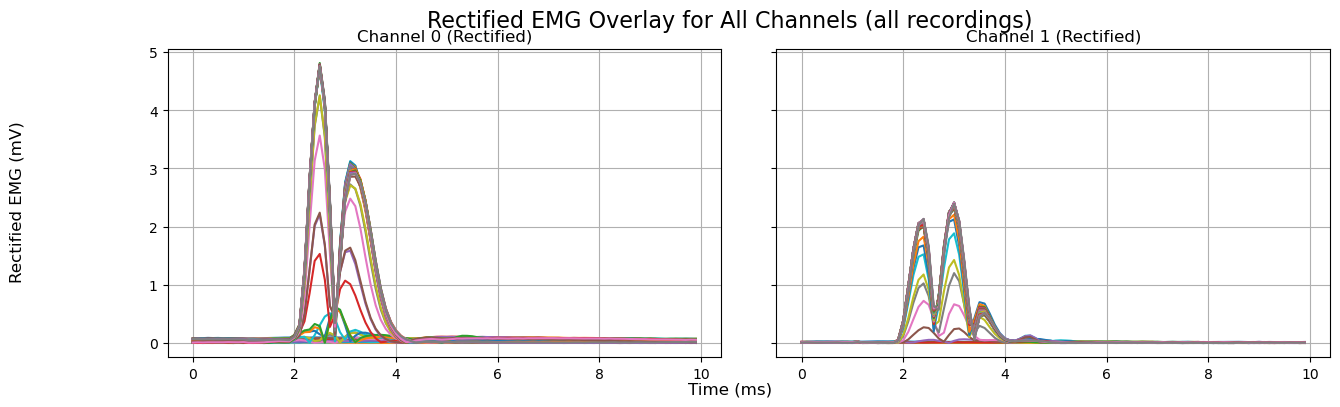

In [7]:
# Plot rectified EMG data for all channels

def rectify_emg(data):
    """
    Rectify EMG data by taking the absolute value.
    """
    return np.abs(data)

# Load the session data from the pickle file
with open(pickled_test_data, 'rb') as pickle_file:
    session_data = pickle.load(pickle_file)

# Access session-wide information
session_info = session_data['session_info']
scan_rate = session_info['scan_rate']
num_samples = session_info['num_samples']
num_channels = session_info['num_channels']

# Access recordings and sort by stimulus_value
recordings = sorted(session_data['recordings'], key=lambda x: x['stimulus_v'])

# Calculate time values based on the scan rate
time_values_ms = np.arange(num_samples) * 1000 / scan_rate  # Time values in milliseconds

# Determine the number of samples for the first 10ms
time_window_ms = 10  # Time window in milliseconds
num_samples_time_window = int(time_window_ms * scan_rate / 1000)  # Convert time window to number of samples

# Slice the time array for the time window
time_window_ms = time_values_ms[:num_samples_time_window]

# Create a figure and axis
if num_channels == 1:
    fig, ax = plt.subplots(figsize=(8, 4))
    axes = [ax]
else:
    fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(15, 4), sharey=True)

# Plot the rectified EMG arrays for each channel, only for the first 10ms
for recording in recordings:
    for channel_index, channel_data in enumerate(recording['channel_data']):
        rectified_channel_data = rectify_emg(channel_data)
        if num_channels == 1:
            ax.plot(time_window_ms, rectified_channel_data[:num_samples_time_window], label=f"Stimulus Voltage: {recording['stimulus_v']}")
            ax.set_title('Channel 0 (Rectified)')
            ax.grid(True)
            #ax.legend()
        else:
            axes[channel_index].plot(time_window_ms, rectified_channel_data[:num_samples_time_window], label=f"Stimulus Voltage: {recording['stimulus_v']}")
            axes[channel_index].set_title(f'Channel {channel_index} (Rectified)')
            axes[channel_index].grid(True)
            #axes[channel_index].legend()

# Set labels and title
if num_channels == 1:
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Rectified EMG (mV)')
    fig.suptitle('Rectified EMG Overlay for Channel 0 (all recordings)', fontsize=16)
else:
    fig.suptitle('Rectified EMG Overlay for All Channels (all recordings)', fontsize=16)
    fig.supxlabel('Time (ms)')
    fig.supylabel('Rectified EMG (mV)')

    # Adjust subplot spacing
    plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()

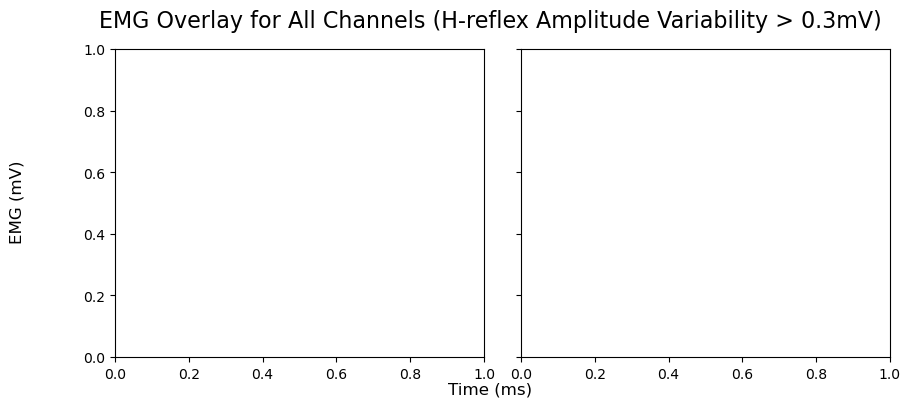

In [115]:
# Plot possible H-reflex EMGs for all channels
h_start = 5.5 #in ms
h_end = 10 #in ms


# Load the session data from the pickle file
with open(pickled_test_data, 'rb') as pickle_file:
    session_data = pickle.load(pickle_file)

# Access session-wide information
session_info = session_data['session_info']
scan_rate = session_info['scan_rate']
num_samples = session_info['num_samples']
num_channels = session_info['num_channels']

# Access recordings and sort by stimulus_value
recordings = sorted(session_data['recordings'], key=lambda x: x['stimulus_v'])

# Calculate time values based on the scan rate
time_values_ms = np.arange(num_samples) * 1000 / scan_rate  # Time values in milliseconds

# Determine the number of samples for the first 10ms
time_window_ms = 10  # Time window in milliseconds
num_samples_time_window = int(time_window_ms * scan_rate / 1000)  # Convert time window to number of samples

# Slice the time array for the time window
time_window_ms = time_values_ms[:num_samples_time_window]

# Create a figure and axis
if num_channels == 1:
    fig, ax = plt.subplots(figsize=(8, 4))
    axes = [ax]
else:
    fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(10, 4), sharey=True)

# Plot the EMG arrays for each channel, only for the first 10ms
for recording in recordings:
    for channel_index, channel_data in enumerate(recording['channel_data']):
        if num_channels == 1:
            h_window = recording['channel_data'][channel_index][int(h_start * scan_rate / 1000):int(h_end * scan_rate / 1000)]
            if max(h_window) - min(h_window) > 0.3:  # Check amplitude variation within 5-10ms window
                ax.plot(time_window_ms, channel_data[:num_samples_time_window], label=f"Stimulus Voltage: {recording['stimulus_v']}")
                ax.set_title('Channel 0')
                ax.grid(True)
                ax.legend()
        else:
            h_window = recording['channel_data'][channel_index][int(h_start * scan_rate / 1000):int(h_end * scan_rate / 1000)]
            if max(h_window) - min(h_window) > 0.3:  # Check amplitude variation within 5-10ms window
                axes[channel_index].plot(time_window_ms, channel_data[:num_samples_time_window], label=f"Stimulus Voltage: {recording['stimulus_v']}")
                axes[channel_index].set_title(f'Channel {channel_index}')
                axes[channel_index].grid(True)
                axes[channel_index].legend()

# Set labels and title
if num_channels == 1:
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('EMG (mV)')
    fig.suptitle('EMG Overlay for Channel 0 (H-reflex Amplitude Variability > 0.3mV)', fontsize=16)
else:
    fig.suptitle('EMG Overlay for All Channels (H-reflex Amplitude Variability > 0.3mV)', fontsize=16)
    fig.supxlabel('Time (ms)')
    fig.supylabel('EMG (mV)')

    # Adjust subplot spacing
    plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()

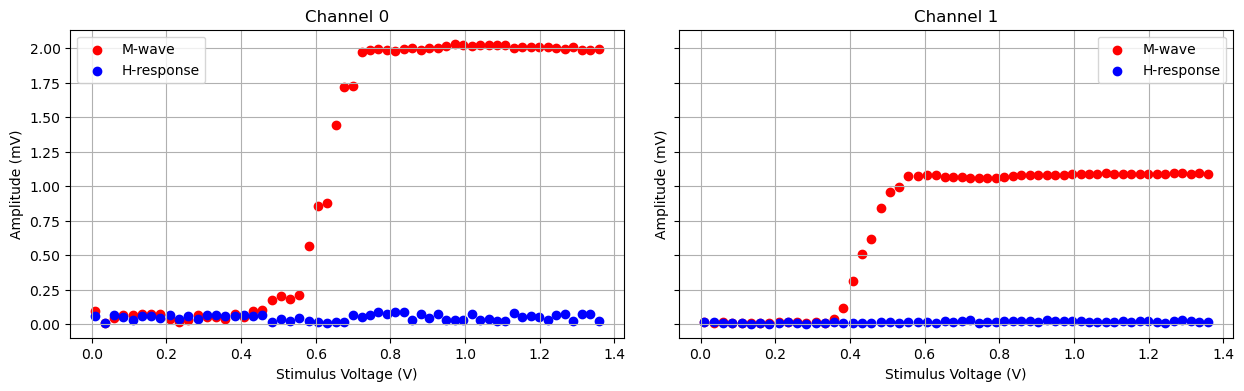

In [9]:
import numpy as np

def rectify_emg(data):
    """
    Rectify EMG data by taking the absolute value.
    """
    return np.abs(data)

def calculate_response_amplitude(emg_data, start_ms, end_ms, scan_rate):
    """
    Calculate the average rectified EMG amplitude between start_ms and end_ms.
    """
    start_index = int(start_ms * scan_rate / 1000)
    end_index = int(end_ms * scan_rate / 1000)
    emg_window = emg_data[start_index:end_index]
    rectified_emg_window = rectify_emg(emg_window)
    return np.mean(rectified_emg_window)

# Load the session data from the pickle file
with open(pickled_test_data, 'rb') as pickle_file:
    session_data = pickle.load(pickle_file)

# Access session-wide information
session_info = session_data['session_info']
scan_rate = session_info['scan_rate']
num_channels = session_info['num_channels']

# Access recordings and sort by stimulus_value
recordings = sorted(session_data['recordings'], key=lambda x: x['stimulus_v'])

# Define the time windows for M-wave and H-response
m_start_ms = 2  # Start time for M-wave (in ms)
m_end_ms = 4  # End time for M-wave (in ms)
h_start_ms = 4  # Start time for H-response (in ms)
h_end_ms = 7  # End time for H-response (in ms)

# Create a figure and axis
if num_channels == 1:
    fig, ax = plt.subplots(figsize=(8, 4))
    axes = [ax]
else:
    fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(15, 4), sharey=True)

# Plot the M-wave and H-response amplitudes for each channel
for channel_index in range(num_channels):
    m_wave_amplitudes = []
    h_response_amplitudes = []
    stimulus_voltages = []

    for recording in recordings:
        channel_data = recording['channel_data'][channel_index]
        stimulus_v = recording['stimulus_v']

        m_wave_amplitude = calculate_response_amplitude(channel_data, m_start_ms, m_end_ms, scan_rate)
        h_response_amplitude = calculate_response_amplitude(channel_data, h_start_ms, h_end_ms, scan_rate)

        m_wave_amplitudes.append(m_wave_amplitude)
        h_response_amplitudes.append(h_response_amplitude)
        stimulus_voltages.append(stimulus_v)

    if num_channels == 1:
        ax.scatter(stimulus_voltages, m_wave_amplitudes, color='r', label='M-wave', marker='o')
        ax.scatter(stimulus_voltages, h_response_amplitudes, color='b', label='H-response', marker='o')
        ax.set_title('Channel 0')
        ax.set_xlabel('Stimulus Voltage (V)')
        ax.set_ylabel('Amplitude (mV)')
        ax.grid(True)
        ax.legend()
    else:
        axes[channel_index].scatter(stimulus_voltages, m_wave_amplitudes, color='r', label='M-wave', marker='o')
        axes[channel_index].scatter(stimulus_voltages, h_response_amplitudes, color='b', label='H-response', marker='o')
        axes[channel_index].set_title(f'Channel {channel_index}')
        axes[channel_index].set_xlabel('Stimulus Voltage (V)')
        axes[channel_index].set_ylabel('Amplitude (mV)')
        axes[channel_index].grid(True)
        axes[channel_index].legend()

# Adjust subplot spacing (only if there are multiple channels)
if num_channels > 1:
    plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()